# Training a Convolutional Neural Network to solve minesweeper
## Description
I wanted to learn a bit of tensorflow, and also to solve the minesweeper problem. At first, (a year ago), I thought to use basic machine learning, but didn’t succeed because I barely knew how to do anything.
The idea was to train a network, that gets a partially open board and tries to predict where the mines are on the board.
We then use this network to look at the game-board and find the square with the least likelihood of being a mine. We then open it and predict once more on the updated game-board, and so on.
## Code

In [2]:
#%% Importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [3]:
#%% Create board
def createBoard(boardSize, mineNum):
  """
    Creates a board given the size of the board (a square), and the number of
    mines. It places the mines randomaly, then runs over all squares and
    whenever there is a mine, it adds 1 to all 8 neighbours.
  """
  # put the mines in random places
  A = np.zeros([boardSize, boardSize])
  for ii in range(mineNum): # randomly allocate mine
    randX = np.random.randint(0, boardSize - 1)
    randY = np.random.randint(0, boardSize - 1)
    while A[randX, randY] == 9: # while the place already has a mine
      randX = np.random.randint(0, boardSize - 1)
      randY = np.random.randint(0, boardSize - 1)
    A[randX, randY] = 9
  B = np.zeros([boardSize, boardSize])
  midY = boardSize / 2 #-(1-size)/2
  midX = midY
  # the following creates the numbers around the board
  for y1 in range(boardSize):
    for x1 in range(boardSize):
      if A[y1, x1]==9:
        for e in [-1, 0,  1]:
          for f in [-1, 0, 1]:
            if e*e + f*f != 0 and abs(y1 + e - midY) <= midY and \
            abs(x1 + f - midX) <= midX:
              if A[y1 + e, x1 + f] != 9:
                B[y1 + e, x1 + f] = B[y1 + e, x1 + f] + 1
  board = A + B
  return board

In [4]:
#%% Draw board
def drawBoard(boardMat, imgPath):
  """
    Receives the matrix description of the board, and the path to the images
    of the numbers and mine and flag, and creates the board.
  """
  # load images
  currImg = mpimg.imread(imgPath + '\\' + str(0) + '.png')
  imshp = currImg.shape[:2] # relays on the fact that all images are the same size
  boardImg = np.zeros([boardMat.shape[0] * imshp[0], boardMat.shape[1] * imshp[1], 3])
  for ii in range(boardMat.shape[0]):
    for jj in range(boardMat.shape[1]):
      boardImg[ii*imshp[0]:(ii+1)*imshp[0], jj*imshp[1]:(jj+1)*imshp[1], :] = \
           mpimg.imread(imgPath + '\\' + str(int(boardMat[ii, jj])) + '.png')
  plt.figure(figsize=(8, 8))
  plt.imshow(boardImg)
  return boardImg

In [5]:
#%% Create partial board for training, and testing
def createPartialBoards(N, boardSize, mineNum): # N is the number of boards
  """ We'll get a random number of open squares for each board, create N boards, 
      and then get a partial solution and the binary solution"""
  boardGT  = [] # list of boards
  openRand = np.random.randint(boardSize*boardSize, size = N) # random number of open squares
  openRand = openRand.tolist()
  trainBrd = [] # list of the partial boards for training
  boardSol = [] # list of the solutions for the training boards
  for ii in range(N):
    # create board
    currBoard = createBoard(boardSize, mineNum)
    boardGT.append(currBoard)
    # create partial board
    currRand = np.random.randint(boardSize, size = [openRand[ii], 2]) # the location of the open squares
    currRand = currRand.tolist()
    currPrtl = 10 * np.ones([boardSize, boardSize])
    for jj in range(openRand[ii]):
      currPrtl[currRand[jj][0], currRand[jj][1]] = currBoard[currRand[jj][0], currRand[jj][1]]
    trainBrd.append(currPrtl)
    # create solution
    currSol  = (currBoard == 9)
    boardSol.append(currSol)
  boardGT  = np.array(boardGT)
  boardGT  = boardGT[:,:,:,np.newaxis]
  trainBrd = np.array(trainBrd)
  trainBrd = trainBrd[:,:,:,np.newaxis]
  boardSol = np.array(boardSol)
  boardSol = boardSol[:,:,:,np.newaxis]
  return boardGT, trainBrd, boardSol

In [6]:
#%% Create network
def createCNN(boardSize):
  CNet = tf.keras.Sequential()
  CNet.add(tf.keras.layers.Conv2D(32, 3, activation = 'relu', 
           input_shape = (boardSize, boardSize, 1), name = 'conv1'))
  CNet.add(tf.keras.layers.Conv2D(64, 3, activation = 'relu', name = 'conv2')) # use_bias = 1, 
  CNet.add(tf.keras.layers.Conv2D(128, 3, activation = 'relu', name = 'conv3'))
  CNet.add(tf.keras.layers.Conv2DTranspose(128, 3, activation = 'relu', name = 'deconv1'))
  CNet.add(tf.keras.layers.Conv2DTranspose(128, 3, activation = 'relu', name = 'deconv2'))
  CNet.add(tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', name = 'deconv3'))
  #CNet.add(tf.keras.layers.Dense(32, name = 'dense1'))
  CNet.add(tf.keras.layers.Dense(1, name = 'dense1'))
  # compile
  CNet.compile(optimizer = tf.train.AdamOptimizer(0.001), loss = 'mse', metrics = ['accuracy'])
  print('CNet.summary():')
  CNet.summary()
  return CNet

In [7]:
#%% Show prediction output
def showPrediction(currGT, currBrd, currSol, currOut, thresh, imgPath):
  GTImg  = drawBoard(currGT, imgPath)
  BrdImg = drawBoard(currBrd, imgPath)
  SolImg = drawBoard(9*currSol, imgPath)
  # Out is between 0 and 1, so we'll use a threshold, and then multiply by 9:
  outMat = 9*(currOut > thresh)
  OutImg = drawBoard(outMat, imgPath)
  plt.figure(figsize=(15,15))
  plt.subplot(221)
  plt.imshow(GTImg)
  plt.title('Ground Truth')
  plt.subplot(222)
  plt.imshow(BrdImg)
  plt.title('Training board')
  plt.subplot(223)
  plt.imshow(SolImg)
  plt.title('Real solution')
  plt.subplot(224)
  plt.imshow(OutImg)
  plt.title('Auto solution')

In [8]:
#%% open zeros neighbors opens all the neighbors of some index, given that its
# value is 0.
def openZerosNeighbors(gameBoard, GTBoard, ind, cntr):
  midY = gameBoard.shape[1] / 2 #-(1-size)/2
  midX = midY
  Y = gameBoard.shape[1]
  X = gameBoard.shape[1]
  for e in [-1, 0,  1]:
    for f in [-1, 0, 1]:
      newInd =[0, ind[1] + e, ind[2] + f, 0]
      # print(newInd)
      if e*e + f*f > 0 and newInd[1] >= 0 and newInd[1] < Y and newInd[2] >= 0 and newInd[2] < X:
      #if e*e + f*f > 0 and abs(newInd[1] - midY) <= midY and abs(newInd[2] - midX) <= midX:
        if gameBoard[newInd[0], newInd[1], newInd[2], newInd[3]] == 10:
          gameBoard[newInd[0], newInd[1], newInd[2], newInd[3]] = GTBoard[newInd[1], newInd[2]]
          cntr += 1
          if gameBoard[newInd[0], newInd[1], newInd[2], newInd[3]] == 0: # we landed on a 0
            gameBoard, cntr = openZerosNeighbors(gameBoard, GTBoard, newInd, cntr)
  return gameBoard, cntr

In [9]:
#%% Play games and check if you win or lose, and return the number of steps until you finish
def playGame(boardSize, mineNum, CNet, imgPath, showOutcome, open0, expFlag):
  # showOutcome is a boolian for whther to print and show or not
  GTBoard = createBoard(boardSize, mineNum)
  # We also need the changing board:
  gameBoard = 10 * np.ones([1, boardSize, boardSize, 1])
  # And now we need a while loop that predicts the board and opens the least
  # probable square (closest to nil):
  done = 0
  cntr = 0 # counter of the number of steps
  while done == 0:
    cntr = cntr + 1
    if expFlag:
      predBoard = CNet.predict(np.log10(gameBoard + 0.1))
    else:
      predBoard = CNet.predict(gameBoard)
    # We need to force the machine to pick squares he hasn't picked yet, so we subtract the gameboard values (10)
    ind = np.unravel_index(np.argmin(predBoard - gameBoard, axis=None), predBoard.shape)
    gameBoard[ind] = GTBoard[ind[1:3]]
    if GTBoard[ind[1:3]] == 9: # landed on a mine
      done = 1
      if showOutcome:
        print('You LOST :(')
    if cntr == boardSize**2 - mineNum:
      done = 1
      if showOutcome:
        print('You WON :)')
    if open0 and gameBoard[ind] == 0: # open0 - open neighbors of 0, and we landed on a 0
      gameBoard, cntr = openZerosNeighbors(gameBoard, GTBoard, ind, cntr)
  # Show the outcome
  if showOutcome:
    GTImg   = drawBoard(GTBoard, imgPath)
    gameImg = drawBoard(np.squeeze(gameBoard), imgPath)
    plt.figure(figsize=(16, 16))
    plt.subplot(211)
    plt.imshow(GTImg)
    plt.title('Ground Truth')
    plt.subplot(212)
    plt.imshow(gameImg)
    plt.title('Game Board')
    print(cntr)
  return cntr

In [10]:
#%% test the program:
def testCNet(testN, showOutcome, open0, boardSize, mineNum, imgPath, expFlag):
  maxCnt = boardSize**2 - mineNum # the number of steps needed to win
  stepCnt = np.zeros(testN)
  for ii in range(testN):
    stepCnt[ii] = playGame(boardSize, mineNum, CNet, imgPath, showOutcome, open0, expFlag)
  
  # show the histogram:
  plt.figure(figsize=(10,10))
  gamehist = plt.hist(stepCnt, maxCnt)
  winRate  = np.sum(stepCnt == maxCnt) / (testN - np.sum(stepCnt == 1)) # success rate not including first time failiures
  print(winRate)
  return 0

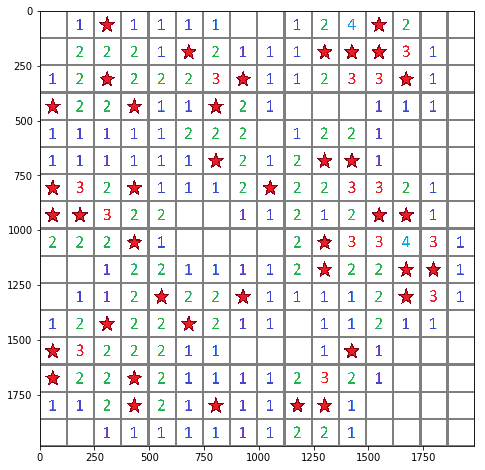

In [12]:
#%% Main:
# create a board as an example, and then show it:
  # We'll try intermediate, which is 16x16 with 40 mines
boardSize = 16
mineNum = 40
board = createBoard(boardSize, mineNum)
imgPath = '.\\MineSweeper' # the path where the images of the 
boardImg = drawBoard(board, imgPath) # draw the board in an understandable manner

In [13]:
#%% create data:
# We want partial boards in all the different stages, and their solutions - a 
# binary board with 1's for mines and 0's for all else.
# Lets assume we have N boards:
N = 400000
expFlag = 1
# Now we want to create the boards:
boardDat, trainBrd, boardSol = createPartialBoards(N, boardSize, mineNum)
if expFlag:
  boardDat = np.log10(boardDat + 0.1)
  trainBrd = np.log10(trainBrd + 0.1)
# split into training and validation
splitInt = int(0.9 * N)
validDat = trainBrd[splitInt:]
validSol = boardSol[splitInt:]
trainDat = trainBrd[:splitInt]
trainSol = boardSol[:splitInt]

In [14]:
#%% Create Network
# Saving network
checkpoint_path = ".\\checkpoint9\\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
# create the network
CNet = createCNN(boardSize)
# Now we want to train the network:
CNet.fit(trainDat, trainSol, epochs = 10, batch_size = 128, 
         validation_data = (validDat, validSol), callbacks = [cp_callback])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CNet.summary():
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 12, 64)        18496     
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 10, 128)       73856     
_________________________________________________________________
deconv1 (Conv2DTranspose)    (None, 12, 12, 128)       147584    
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 14, 14, 128)       147584    
_________________________________________________________________
deconv3 (Conv2DTranspose)    (None, 16, 16, 64)        73792     
______

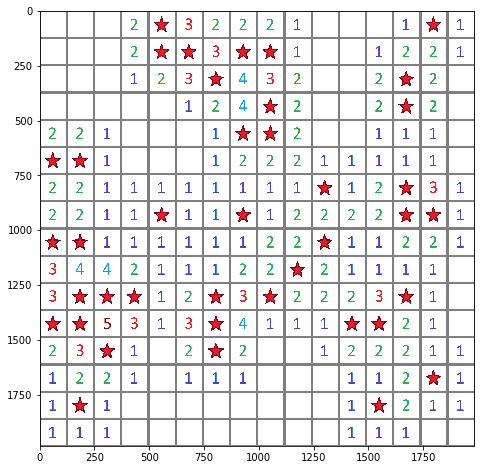

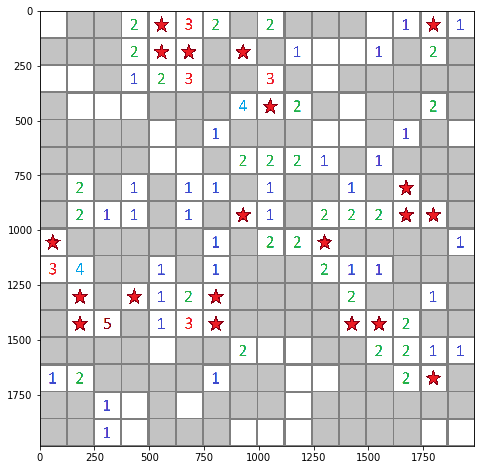

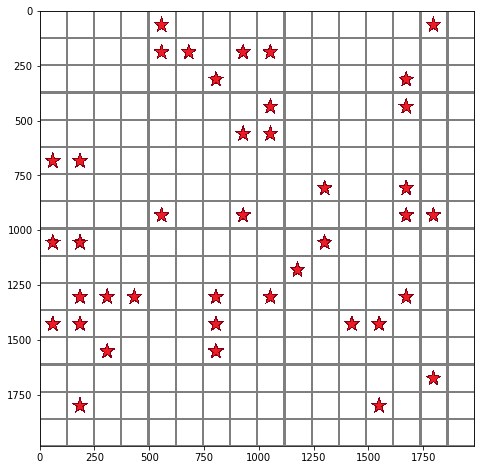

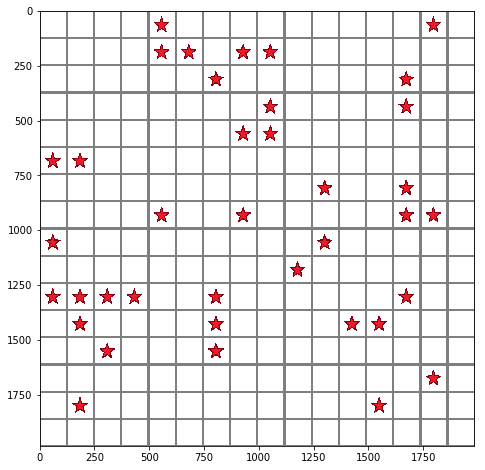

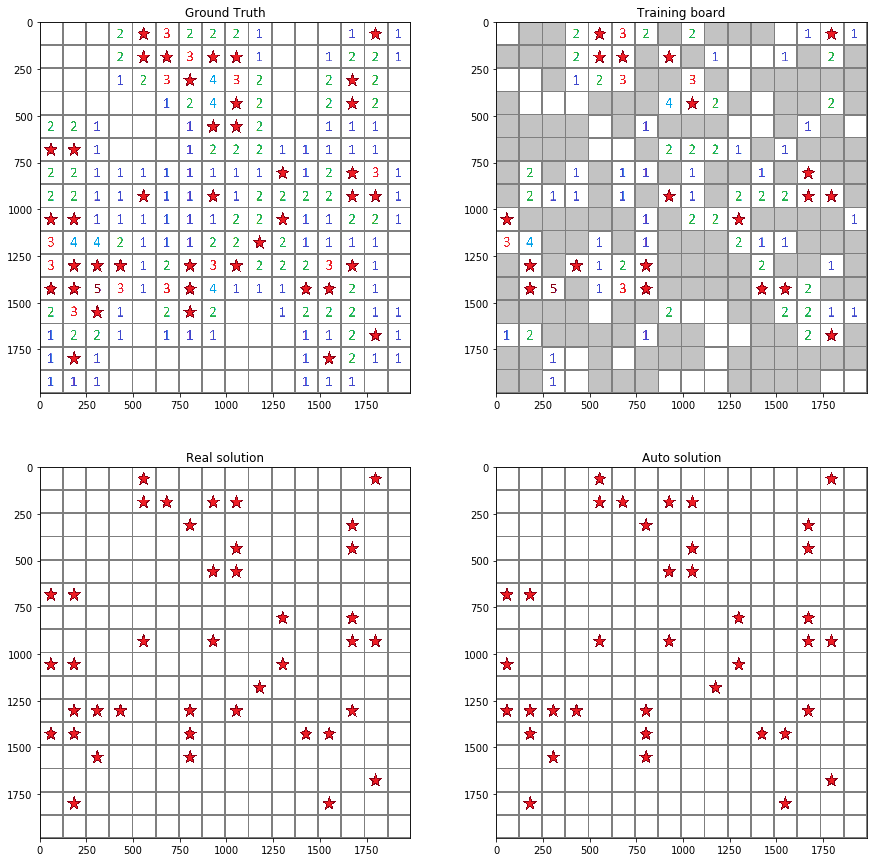

In [15]:
#%% Test:
# create another board, and look at the solution
threshold = 0.5 # threshold above which we think we have a mine
#create a board:
testGT, testBrd, testSol = createPartialBoards(1, boardSize, mineNum)
testOut = CNet.predict(np.log10(testBrd+0.1))
ii = 0;
currGT  = np.squeeze(testGT [ii,:,:])
currBrd = np.squeeze(testBrd[ii,:,:])
currSol = np.squeeze(testSol[ii,:,:])
currOut = np.squeeze(testOut[ii,:,:])
showPrediction(currGT, currBrd, currSol, currOut, threshold, imgPath)

0.662


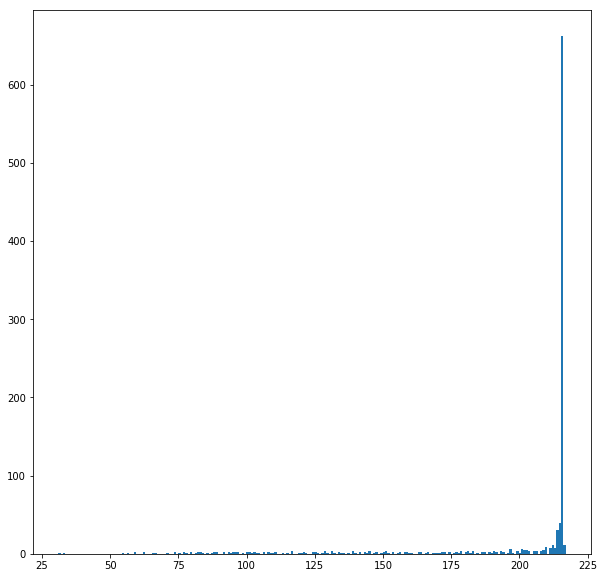

In [16]:
#%% Now we want a system that gets a board, and plays it.
# We'll make a game board, and then use it to 
testN = 1000 # number of games to test
showOutcome = 0
open0 = 1
test = testCNet(testN, showOutcome, open0, boardSize, mineNum, imgPath, expFlag)

## I tried various networks:
